# Квантизация нейронных сетей

В этой лабораторной попробуем уменьшить размер нейронной сети, а также усторить ее работу, заменяя float на int внутри сети.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import copy

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from torch.quantization import QuantStub, DeQuantStub

In [2]:
SEED=9876
torch.manual_seed(SEED)

Вновь пробуем обучить сеть из трех полносвязных слоев на fashion mnist.

In [3]:
train_csv = pd.read_csv("/data/fashion-mnist_train.csv")
test_csv = pd.read_csv("/data/fashion-mnist_test.csv")

In [4]:
device = torch.device("cpu")

In [5]:
train_csv.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y_train = train_csv['label'].values
X_train = train_csv.drop(['label'],axis=1).values

y_test = test_csv['label'].values
X_test = test_csv.drop(['label'],axis=1).values

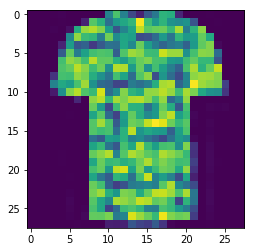

In [7]:
plt.imshow(X_train[3].reshape(28, 28))

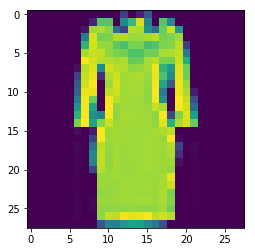

In [8]:
plt.imshow(X_train[4].reshape(28, 28))

In [9]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

In [63]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return X

mlp = MLP()
print(mlp)

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


In [64]:
def fit(model, train_loader, epoch_number=5):
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epoch_number):
        correct = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            if batch_idx % 200 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [17]:
def evaluate(model, loader=test_loader):
    correct = 0 
    for test_imgs, test_labels in loader:
        test_imgs = Variable(test_imgs).float()
        
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct) / (len(loader)*BATCH_SIZE)))

In [66]:
torch.manual_seed(SEED)
fit(mlp, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 11.756062	 Accuracy:18.750%
Epoch : 0 [6400/60000 (11%)]	Loss: 0.620706	 Accuracy:69.667%
Epoch : 0 [12800/60000 (21%)]	Loss: 0.742245	 Accuracy:74.018%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.313909	 Accuracy:75.790%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.438836	 Accuracy:76.931%
Epoch : 0 [32000/60000 (53%)]	Loss: 0.558625	 Accuracy:77.791%
Epoch : 0 [38400/60000 (64%)]	Loss: 0.357680	 Accuracy:78.505%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.413693	 Accuracy:78.988%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.265867	 Accuracy:79.443%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.315978	 Accuracy:79.775%
Epoch : 1 [0/60000 (0%)]	Loss: 0.553459	 Accuracy:84.375%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.423689	 Accuracy:83.349%
Epoch : 1 [12800/60000 (21%)]	Loss: 0.699665	 Accuracy:83.541%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.190550	 Accuracy:83.683%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.260512	 Accuracy:83.844%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.529210	 Accuracy:83.891%
Epo

In [67]:
evaluate(mlp)

Test accuracy:0.858% 


Уменьшать количество самих весов в этот раз мы не будем, поэтому в качестве размера нейронной сети будет использовать буквально количество памяти, которая она занимает.

In [82]:
def calc_size(model):
    torch.save(model.state_dict(), "/tmp/model.p")
    size=os.path.getsize("/tmp/model.p")
    os.remove('/tmp/model.p')
    return "{:.3f} KB".format(size / 1024)

In [69]:
calc_size(mlp)

'870.694 KB'

Полученная сеть весит почти мегабайт.

Посмотрим на веса, которые используются внутри нашей сети

In [70]:
mlp.linear1.weight

Parameter containing:
tensor([[ 0.0417,  0.0319,  0.1002,  ...,  0.1496,  0.2197,  0.0276],
        [ 0.0319,  0.0167,  0.0228,  ...,  0.0036, -0.0232, -0.0021],
        [-0.0136,  0.0015, -0.0036,  ...,  0.0028, -0.0361, -0.0615],
        ...,
        [ 0.0304, -0.0115, -0.0250,  ..., -0.0063, -0.0719, -0.0729],
        [ 0.0178, -0.0027, -0.0122,  ..., -0.0703,  0.0111, -0.0264],
        [-0.0081,  0.0118,  0.0321,  ..., -0.0154,  0.0246,  0.0243]],
       requires_grad=True)

In [71]:
mlp

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)

Посчитаем дополнительно, за сколько в среднем она делает предсказания. Для замеров по времени будем использовать один поток, чтобы все сети были в одинаковых условиях.

In [72]:
from contextlib import contextmanager

@contextmanager
def single_thread():  
    num = torch.get_num_threads()
    torch.set_num_threads(1)
    yield
    torch.set_num_threads(num)

In [95]:
%%timeit -r10

with single_thread():
    evaluate(mlp, train_loader)

Test accuracy:0.867% 
Test accuracy:0.867% 
Test accuracy:0.867% 
Test accuracy:0.867% 
Test accuracy:0.867% 
Test accuracy:0.867% 
Test accuracy:0.867% 
Test accuracy:0.867% 
Test accuracy:0.867% 
Test accuracy:0.867% 
Test accuracy:0.867% 
2.12 s ± 240 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


# Динамическая квантизация

Динамическая квантизация - пожалуй самый простой способ квантизации. 

Все веса из float мы сразу переводим в int, а вот активации мы пересчитываем на лету во время работы сети. Для каждого примера в нейроне мы аккумулируем взвешенную сумму по-честному во float, подбираем для конкретного получившегося числа лучшие параметры квантизации, квантуем и отправляем дальше по сети.

Таким образом, из-за этих автоматических квантований во время работы сети сеть все еще может работать медленно.

Попробуем применить динамическую квантизацию к нашей модели.

In [74]:
qd_mlp = torch.quantization.quantize_dynamic(
    mlp, {nn.Linear}, dtype=torch.qint8
)

In [75]:
qd_mlp

MLP(
  (linear1): DynamicQuantizedLinear(in_features=784, out_features=250, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (linear2): DynamicQuantizedLinear(in_features=250, out_features=100, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (linear3): DynamicQuantizedLinear(in_features=100, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [76]:
calc_size(qd_mlp)

'222.215 KB'

Видно, что получилось уменьшить размер сети почти в 4 раза. Посмотрим, что случилось с качеством полученной модели.

In [77]:
evaluate(qd_mlp)

Test accuracy:0.864% 


Качество осталось в точности таким же.

Заглянем в то, какие теперь веса используются внутри.

In [78]:
qd_mlp.linear1.weight().int_repr()

tensor([[  9,   7,  21,  ...,  32,  47,   6],
        [  7,   4,   5,  ...,   1,  -5,   0],
        [ -3,   0,  -1,  ...,   1,  -8, -13],
        ...,
        [  6,  -2,  -5,  ...,  -1, -15, -15],
        [  4,  -1,  -3,  ..., -15,   2,  -6],
        [ -2,   3,   7,  ...,  -3,   5,   5]], dtype=torch.int8)

In [79]:
mlp.linear1.weight

Parameter containing:
tensor([[ 0.0417,  0.0319,  0.1002,  ...,  0.1496,  0.2197,  0.0276],
        [ 0.0319,  0.0167,  0.0228,  ...,  0.0036, -0.0232, -0.0021],
        [-0.0136,  0.0015, -0.0036,  ...,  0.0028, -0.0361, -0.0615],
        ...,
        [ 0.0304, -0.0115, -0.0250,  ..., -0.0063, -0.0719, -0.0729],
        [ 0.0178, -0.0027, -0.0122,  ..., -0.0703,  0.0111, -0.0264],
        [-0.0081,  0.0118,  0.0321,  ..., -0.0154,  0.0246,  0.0243]],
       requires_grad=True)

Помотрим, насколько быстро получается делать предсказания квантизированной моделью.

In [96]:
%%timeit -r10

with single_thread():
    evaluate(qd_mlp, train_loader)

Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
Test accuracy:0.871% 
1.27 s ± 14.5 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


На моем компьютере получился прирост примерно в 10-15%. Таким образом динамическая квантизация - достаточно простой прием, который не дает большого проигрышал по качеству, при этом уменьшает размер сети и ускоряет предсказания.

Однако это не единственный подход для квантования. 

# Статическая квантизация

Статическая квантизация позволяет сразу все операции перевести в int, без необходимости дополнительно что-то расчитывать в процессе предсказания.

Для того, чтобы при этом качество не сильно пострадало, параметры квантования для разных слоем настраиваются по обучающей выборке.

Таким образом для того, чтобы статически квантизировать сеть, необходимо вначале подключить к ней модуль подсчета параметров (Observer), который будет для каждого слоя расчитывать необходимые параметры квантования по обучающей выборке. После этого один раз необходимо всю выборку прогнать через сеть, чтобы эти модули смогли подсчитать нужные параметры. После чего можно фиксировать полученные параметры и итоговую квантизированную сеть.

In [81]:
class QuantizedMLP(nn.Module):
    def __init__(self):
        super(QuantizedMLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
        # Так как теперь квантизация не происходит динамически, необходимо дополнительно 
        # руками квантовать входные данные и деквантовать ответ
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
    
    def forward(self,X):
        # Квантуем входные данные
        X = self.quant(X)
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        # Деквантуем ответ
        X = self.dequant(X)
        return X

In [82]:
ptq_mlp = QuantizedMLP()

In [83]:
torch.manual_seed(SEED)
fit(ptq_mlp, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 11.684027	 Accuracy:18.750%
Epoch : 0 [6400/60000 (11%)]	Loss: 0.787137	 Accuracy:69.512%
Epoch : 0 [12800/60000 (21%)]	Loss: 0.993065	 Accuracy:73.862%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.325165	 Accuracy:75.577%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.345738	 Accuracy:76.802%
Epoch : 0 [32000/60000 (53%)]	Loss: 0.604350	 Accuracy:77.563%
Epoch : 0 [38400/60000 (64%)]	Loss: 0.563863	 Accuracy:78.294%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.423202	 Accuracy:78.886%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.235911	 Accuracy:79.384%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.193039	 Accuracy:79.607%
Epoch : 1 [0/60000 (0%)]	Loss: 0.515112	 Accuracy:78.125%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.454121	 Accuracy:83.862%
Epoch : 1 [12800/60000 (21%)]	Loss: 0.842713	 Accuracy:83.713%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.260269	 Accuracy:83.668%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.279924	 Accuracy:83.825%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.636968	 Accuracy:83.791%
Epo

In [84]:
evaluate(ptq_mlp)

Test accuracy:0.854% 


In [85]:
# Для моделей мы также можем указать конфиг квантования,
# где в частности может указать библиотеку для работы с квантованными значениями

ptq_mlp.qconfig = torch.quantization.get_default_qconfig('fbgemm')

In [86]:
# Устанавливаем модули подсчета параметров квантования. По умолчанию исползуется HistogramObserver, то есть
# модуль, который рассчтывает параметры на основе гистрограммы распределения значнеий для конкретного слоя
torch.quantization.prepare(ptq_mlp, inplace=True)

PostTrainedQuantizedMLP(
  (linear1): Linear(
    in_features=784, out_features=250, bias=True
    (activation_post_process): HistogramObserver()
  )
  (linear2): Linear(
    in_features=250, out_features=100, bias=True
    (activation_post_process): HistogramObserver()
  )
  (linear3): Linear(
    in_features=100, out_features=10, bias=True
    (activation_post_process): HistogramObserver()
  )
  (quant): QuantStub(
    (activation_post_process): HistogramObserver()
  )
  (dequant): DeQuantStub()
)

In [87]:
# Прогоняем всю обучающую выборку через сеть. Для этого просто считаем качество на данных обучающей выборки
# Само значение нам не интересно, нам важно, чтобы посчитались параметры
evaluate(ptq_mlp, train_loader)

Test accuracy:0.863% 


In [88]:
# Фиксируем полученные веса и параметры квантизации
torch.quantization.convert(ptq_mlp, inplace=True)

PostTrainedQuantizedMLP(
  (linear1): QuantizedLinear(in_features=784, out_features=250, scale=48.7363166809082, zero_point=91, qscheme=torch.per_channel_affine)
  (linear2): QuantizedLinear(in_features=250, out_features=100, scale=10.155464172363281, zero_point=80, qscheme=torch.per_channel_affine)
  (linear3): QuantizedLinear(in_features=100, out_features=10, scale=1.5792425870895386, zero_point=72, qscheme=torch.per_channel_affine)
  (quant): Quantize(scale=tensor([2.0069]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

Можно видеть, какие именно параметры (а именно scale и zero_point) подсчитались для каждого слоя.

In [89]:
calc_size(ptq_mlp)

'229.748 KB'

In [90]:
ptq_mlp.linear1.weight().int_repr()

tensor([[-10, -40, -16,  ...,  70,  13,  54],
        [-15, -49, -36,  ...,   5,  -8, -19],
        [-42, -47,  61,  ...,  23,  68,  57],
        ...,
        [ 35,  -8, -10,  ..., -51,  25, -72],
        [-16,  31,  43,  ...,  41, -75, -47],
        [-84,  66,  68,  ..., -35,  67,  86]], dtype=torch.int8)

In [91]:
evaluate(ptq_mlp)

Test accuracy:0.854% 


Видно, что модель все еще хорошо сжалась, при этом качество немного упало. 

Посмотрим, что по скорости выполнения.

In [97]:
%%timeit -r10

with single_thread():
    evaluate(ptq_mlp, train_loader)

Test accuracy:0.863% 
Test accuracy:0.863% 
Test accuracy:0.863% 
Test accuracy:0.863% 
Test accuracy:0.863% 
Test accuracy:0.863% 
Test accuracy:0.863% 
Test accuracy:0.863% 
Test accuracy:0.863% 
Test accuracy:0.863% 
Test accuracy:0.863% 
1.33 s ± 22.2 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


Видно, что с текущей моделью статическая квантизация работает не так хорошо - качество немного просело, а значительного прироста по времени не наблюдается.

Вместо простых схем квантизации, когда уже обученная модель квантуется, есть и более продвинутые схемы.

# Квантизация в процессе обучения

Этот метод заключается в том, что квантование происходит на каждом шаге градиентного спуска. Теоретически это должно делать более аккуратными относительно квантованных параметров и тем самым получать качество лучше.

In [98]:
qa_mlp = QuantizedMLP()

In [99]:
def quantized_fit(model, train_loader, epoch_number=5):
    optimizer = torch.optim.Adam(model.parameters())
    
    # Ничем особенным процесс обучения не отличается
    # Добавляем конфигурацию, после чего подготавливаем модель для обучения с квантованием
    # Модель внутри себя автоматически будет обновлять веса с учетом квантования
    model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
    torch.quantization.prepare_qat(model, inplace=True)
    
    error = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epoch_number):
        correct = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            if batch_idx % 200 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [100]:
torch.manual_seed(SEED)
quantized_fit(qa_mlp, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 19.953337	 Accuracy:3.125%
Epoch : 0 [6400/60000 (11%)]	Loss: 1.015618	 Accuracy:68.470%
Epoch : 0 [12800/60000 (21%)]	Loss: 1.126122	 Accuracy:72.919%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.382234	 Accuracy:74.698%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.263492	 Accuracy:75.964%
Epoch : 0 [32000/60000 (53%)]	Loss: 0.520338	 Accuracy:76.795%
Epoch : 0 [38400/60000 (64%)]	Loss: 0.406278	 Accuracy:77.542%
Epoch : 0 [44800/60000 (75%)]	Loss: 0.436573	 Accuracy:78.083%
Epoch : 0 [51200/60000 (85%)]	Loss: 0.301557	 Accuracy:78.609%
Epoch : 0 [57600/60000 (96%)]	Loss: 0.401963	 Accuracy:79.013%
Epoch : 1 [0/60000 (0%)]	Loss: 0.458184	 Accuracy:87.500%
Epoch : 1 [6400/60000 (11%)]	Loss: 0.491694	 Accuracy:83.411%
Epoch : 1 [12800/60000 (21%)]	Loss: 0.751592	 Accuracy:83.619%
Epoch : 1 [19200/60000 (32%)]	Loss: 0.368394	 Accuracy:83.663%
Epoch : 1 [25600/60000 (43%)]	Loss: 0.291238	 Accuracy:83.770%
Epoch : 1 [32000/60000 (53%)]	Loss: 0.506257	 Accuracy:83.694%
Epoc

Можно заметить, что обучение идет немного дольше чем обычно

In [106]:
# После обучения с квантованием, фиксируем квантованные веса и параметры
quantized_model = torch.quantization.convert(qa_mlp, inplace=False)
quantized_model

PostTrainedQuantizedMLP(
  (linear1): QuantizedLinear(in_features=784, out_features=250, scale=35.50273513793945, zero_point=88, qscheme=torch.per_channel_affine)
  (linear2): QuantizedLinear(in_features=250, out_features=100, scale=5.187557697296143, zero_point=71, qscheme=torch.per_channel_affine)
  (linear3): QuantizedLinear(in_features=100, out_features=10, scale=0.8892423510551453, zero_point=74, qscheme=torch.per_channel_affine)
  (quant): Quantize(scale=tensor([2.0079]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

In [107]:
evaluate(quantized_model)

Test accuracy:0.865% 


На моем компьютере качество получилось даже чуть выше, чем у оригинальной модели

In [109]:
calc_size(quantized_model)

'229.746 KB'

In [110]:
quantized_model.linear1.weight().int_repr()

tensor([[  -9,   13,  -17,  ...,  -34,  -34,  -65],
        [   9,    4,  -45,  ...,  -13,  -24,   65],
        [ -15,  -88,   29,  ...,  -72,   52,   53],
        ...,
        [  74,   50,  106,  ...,   75,  101,   31],
        [ -58,  -68,   57,  ..., -106,  -79,    8],
        [ -15,   58,  -44,  ...,  115,   37,  -63]], dtype=torch.int8)

In [112]:
%%timeit -r10

with single_thread():
    evaluate(quantized_model, train_loader)

Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
Test accuracy:0.876% 
1.3 s ± 6.6 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


По итогу этих экспериментов можно сказать следующее - универсального метода квантизации не существует, в каждом конкретном случае нужно искать свой подход.

Однако все схемы показывают стабильное уменьшение размера модели при небольшом изменении метрики качества и ускорении расчета предсказаний.